### Reading csvs

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import nltk
from collections import defaultdict
from nltk.probability import FreqDist
from nltk.stem import WordNetLemmatizer

In [64]:
#nltk.download('wordnet')

In [65]:
df1 = pd.read_csv('./dataset/DOSSPRE 1.0Original.csv')
df2 = pd.read_csv('./dataset/software_requirements_extended.csv')
df3 = pd.read_csv('./dataset/data3.csv')
# Creating final csv with combined requirements
final_df = pd.DataFrame(pd.concat([df1['Requirement'], df2['Requirement'], df3['RequirementText']] ,ignore_index=True).str.replace("'",""))
final_df.rename({0:"Requirement"},axis=1,inplace=True)
final_df.head()

,Requirement
0,The system shall detect SQL Injection and XSS ...
1,The system shall analyze the detected vulnerab...
2,The system shall identify acceptable low false...
3,The system shall inspect SSL certificate
4,The system shall generate a report of the dete...


In [66]:
# Use for the first time only 

#final_df.to_csv("./dataset/final_combined.csv")
final_df = pd.read_csv("./dataset/final_combined.csv").reset_index()
del final_df['Unnamed: 0']

## General EDA

In [67]:

from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize

In [68]:
# Character count 
final_df['char_count'] = final_df['Requirement'].map(lambda x: len(x))
# Word counts
final_df["word_count"] = final_df["Requirement"].map(lambda x: len(x.split()))
# String counts
final_df["hashtag_count"] = final_df["Requirement"].map(lambda x: x.count("#"))
# Average word length
final_df["avg_word_len"] = final_df["Requirement"].map(lambda x: np.mean([len(w) for w in str(x).split()]))

final_df.head(10)

,index,Requirement,char_count,word_count,hashtag_count,avg_word_len
0,0,The system shall detect SQL Injection and XSS ...,102,17,0,5.058824
1,1,The system shall analyze the detected vulnerab...,52,7,0,6.428571
2,2,The system shall identify acceptable low false...,62,9,0,5.888889
3,3,The system shall inspect SSL certificate,41,6,0,5.833333
4,4,The system shall generate a report of the dete...,79,12,0,5.666667
5,5,The system shall have a friendly user interfac...,106,17,0,5.235294
6,6,The system shall have a friendly interface des...,79,12,0,5.583333
7,7,The system shall allow parameter inputs to be ...,160,23,0,5.956522
8,8,The system reports shall be delivered in indus...,66,9,0,6.333333
9,9,The system shall be able to carefully diagnose...,135,19,0,6.105263


<Axes: xlabel='avg_word_len', ylabel='Count'>

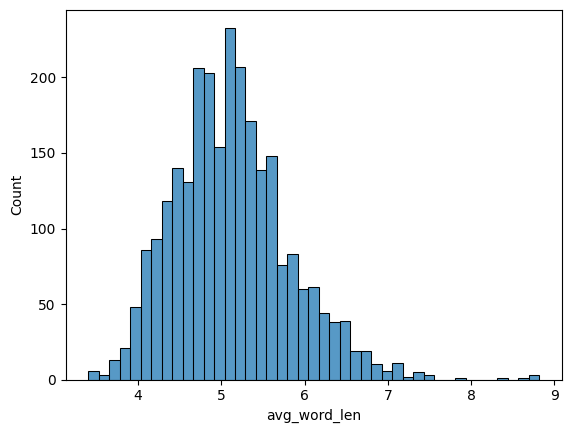

In [69]:
sns.histplot(final_df, x='avg_word_len')

In [70]:
# cleaning the data
import re
import string
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()
    # Remove punctuation
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    # Remove non-Roman characters
    text = re.sub("([^\x00-\x7F])+", " ", text)
    
    text = ''.join([char if ord(char) < 128 else '' for char in text])
    
    return text

In [71]:
final_df["text_clean"] = final_df["Requirement"].map(lambda x: clean_text(x))
final_df.head()

,index,Requirement,char_count,word_count,hashtag_count,avg_word_len,text_clean
0,0,The system shall detect SQL Injection and XSS ...,102,17,0,5.058824,the system shall detect sql injection and xss ...
1,1,The system shall analyze the detected vulnerab...,52,7,0,6.428571,the system shall analyze the detected vulnerab...
2,2,The system shall identify acceptable low false...,62,9,0,5.888889,the system shall identify acceptable low false...
3,3,The system shall inspect SSL certificate,41,6,0,5.833333,the system shall inspect ssl certificate
4,4,The system shall generate a report of the dete...,79,12,0,5.666667,the system shall generate a report of the dete...


In [72]:
# For generating word cloud
from wordcloud import WordCloud
from textwrap import wrap

def generate_wordcloud(data,title):
  wc = WordCloud(width=400, height=330, max_words=150,colormap="Dark2").generate_from_frequencies(data)
  plt.figure(figsize=(10,8))
  plt.imshow(wc, interpolation='bilinear')
  plt.axis("off")
  plt.title('\n'.join(wrap(title,60)),fontsize=13)
  plt.show()

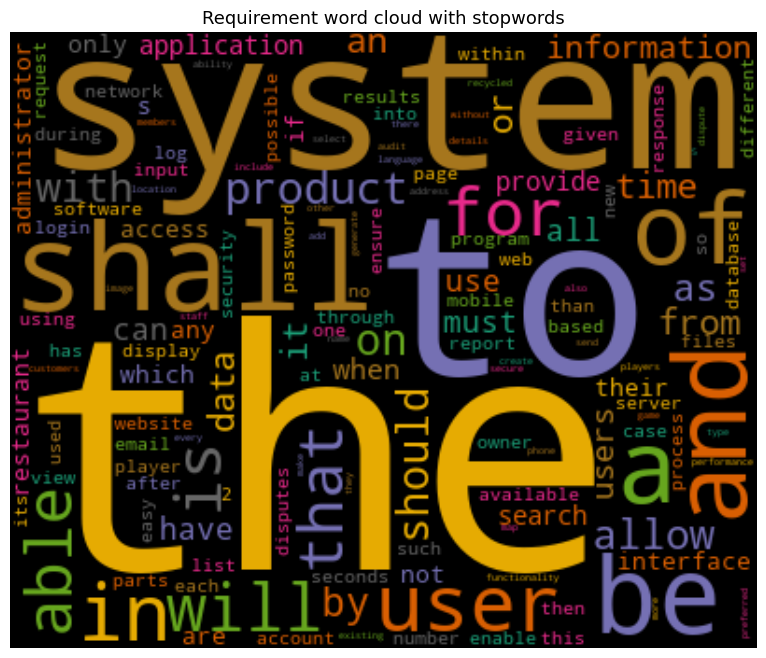

In [73]:
before_clean_words = final_df['text_clean'].str.split()
before_clean_words = before_clean_words.values.tolist()
wordlist =[word for i in before_clean_words for word in i]

from collections import defaultdict

word_dict_with_stopwords=defaultdict(int)
for word in wordlist:
        word_dict_with_stopwords[word]+=1


generate_wordcloud(word_dict_with_stopwords, 'Requirement word cloud with stopwords')

> ### Lemmatizing

In [74]:
# Lemmatizing
lemmatizer = WordNetLemmatizer()

def apply_lemmatize(text):
    
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

final_df['Requirement'] = final_df['Requirement'].apply(apply_lemmatize)

final_df['Requirement'].head()

0    The system shall detect SQL Injection and XSS ...
1    The system shall analyze the detected vulnerab...
2    The system shall identify acceptable low false...
3             The system shall inspect SSL certificate
4    The system shall generate a report of the dete...
Name: Requirement, dtype: object

> ### Removing Stopwords

In [75]:
# creating a corpus with removed stopwords
#nltk.download('stopwords')
stop=set(stopwords.words('english'))
corpus = [ word for i in final_df["text_clean"].str.split().values.tolist() for word in i if (word not in stop) ]
corpus[:10]

['system',
 'shall',
 'detect',
 'sql',
 'injection',
 'xss',
 'vulnerabilities',
 'given',
 'website',
 'web']

In [76]:
# get 15 first most common words from the corpus
common_words = FreqDist(corpus).most_common(15)
common_words

[('system', 1787),
 ('shall', 1717),
 ('user', 667),
 ('able', 440),
 ('product', 410),
 ('allow', 339),
 ('data', 248),
 ('time', 227),
 ('information', 219),
 ('users', 218),
 ('use', 186),
 ('must', 177),
 ('application', 162),
 ('provide', 152),
 ('search', 152)]

<Axes: >

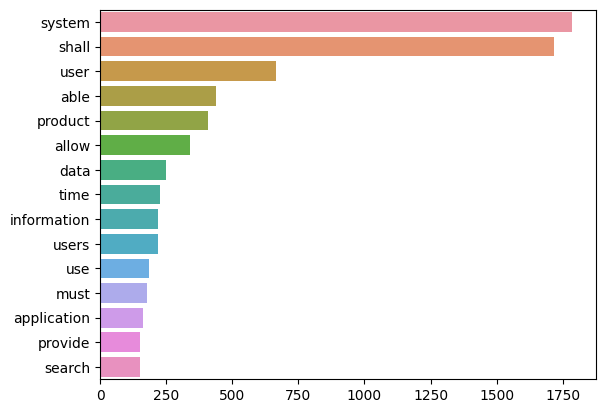

In [77]:
# creating plots for most common words 
words, frequency = [], []
word_freq_dict = {}    
for word, count in common_words:
    words.append(word)
    frequency.append(count)
    word_freq_dict[word] = count

sns.barplot(x = frequency, y = words)

# we can conclude from this graph that generally people don't ask about specific requirement they ususally talk about system as a whole.
# from frequency of "able" and "allow" we can also say that users want security for their application
# from word "data" we can say that people are concerned about the storage and security of the data
# "restaurant" is somewhat strange, maybe there are lot of requirements from the restaurant businesses?

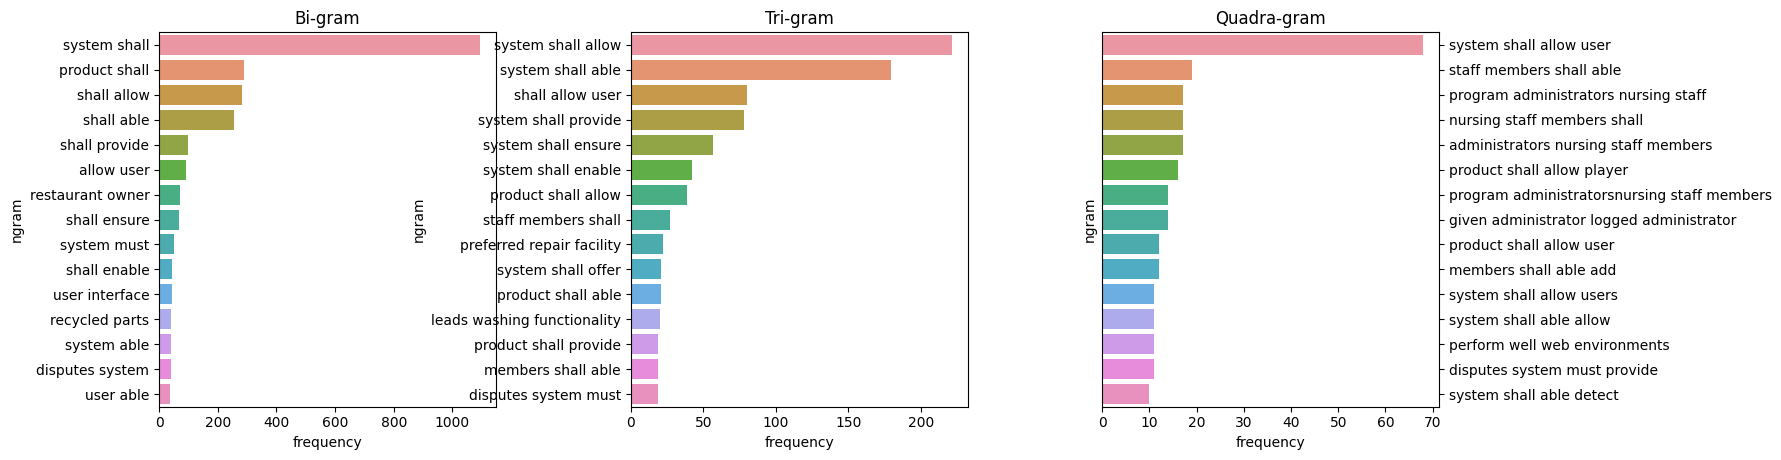

In [78]:
from sklearn.feature_extraction.text import CountVectorizer
def convert_ngram(ngram_range):
    vec = CountVectorizer(stop_words= list(stop), ngram_range=ngram_range)
    # Matrix of ngrams
    bow = vec.fit_transform(final_df["text_clean"])
    # Count frequency of ngrams
    count_values = bow.toarray().sum(axis=0)
    # Create DataFrame from ngram frequencies
    ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in vec.vocabulary_.items()], reverse = True))
    ngram_freq.columns = ["frequency", "ngram"]
    return ngram_freq

bi_ngram = convert_ngram((2,2))
tri_gram = convert_ngram((3,3))
qudra_gram = convert_ngram((4,4))
fig, axis = plt.subplots(1,3)
sns.barplot(data=bi_ngram, y=bi_ngram['ngram'][:15],x=bi_ngram['frequency'][:15], ax=axis[0])
sns.barplot(data=tri_gram, y=tri_gram['ngram'][:15],x=tri_gram['frequency'][:15], ax=axis[1])
sns.barplot(data=qudra_gram, y=qudra_gram['ngram'][:15],x=qudra_gram['frequency'][:15], ax=axis[2])

axis[0].set_title('Bi-gram')
axis[1].set_title('Tri-gram')
axis[2].set_title('Quadra-gram')
axis[2].yaxis.tick_right()
plt.subplots_adjust(left=0.5,
                    bottom=0.1,
                    right=2.5,
                    wspace=0.4,
                    hspace=0.4)



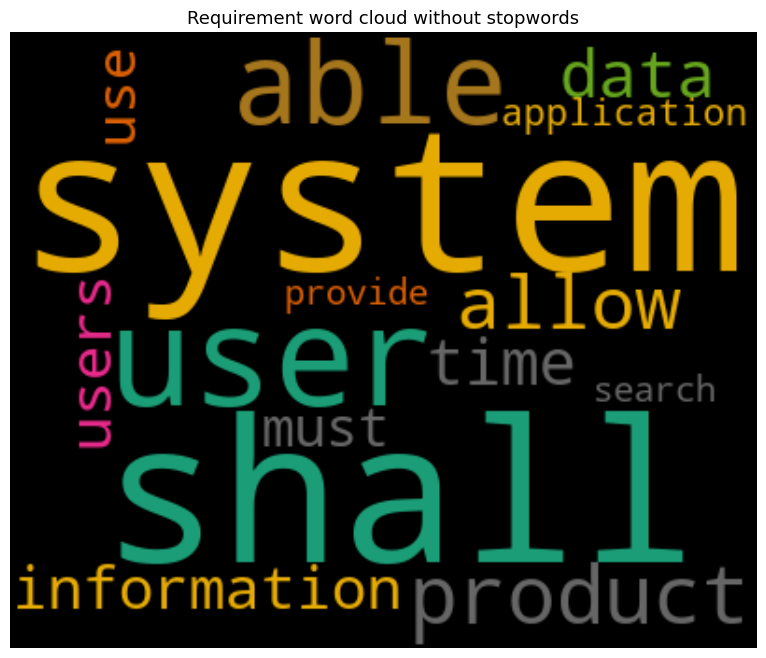

In [79]:
# word cloud after filtering

generate_wordcloud(word_freq_dict, 'Requirement word cloud without stopwords')